In [132]:
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings("ignore")

### Data Loading

In [133]:
data_ = pd.read_csv("../data/FilteredData.csv")

In [134]:
def SingleAtomRemover(x):
    singleAtom = ["[Kr]","[Ne]","C","[Li]","O","[Ar]",'[Xe]']
    if x in singleAtom:
        return 1
    else: 
        return 0  

In [135]:
data = data_[["Structure","BBB+/BBB-"]]

In [136]:
data.replace({"BBB+":1,"BBB-":0},inplace=True)

In [137]:
data.rename(columns={"Structure":"SMILES","BBB+/BBB-":"LABELS"},inplace=True)

In [138]:
data["Isit"] = data["SMILES"].apply(SingleAtomRemover)

In [139]:
### Remove single element
data.drop(data[data["Isit"] == 1].index,inplace=True)

In [140]:
data.to_csv(r"raw/data.csv")

In [141]:
from torch_geometric.data import InMemoryDataset, download_url, Dataset, Data
from dgllife.utils import (CanonicalAtomFeaturizer,
                           one_hot_encoding,
                           atom_implicit_valence_one_hot,
                           atom_total_degree_one_hot,
                           atomic_number_one_hot,
                           atom_hybridization_one_hot,
                           atom_is_in_ring_one_hot,
                           atom_is_aromatic_one_hot
                          )
from rdkit import Chem

class BBBDataset(Dataset): ### All dataset will store in RAM
    
    def __init__(self,root,transform = None, pre_transform=None,pre_filter=None,one_hot=False):
        
        """
        root: where the dataset shoul be stored. The folder will split into raw_dir (downloaded dataset)
        and processed_dir (processed data).

        """
        self.one_hot = one_hot
        super().__init__(root, transform, pre_transform, pre_filter)
        
    
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "data.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        dataArray = self.data[["SMILES","LABELS"]].to_numpy().squeeze()
        
        j = 0
        for i in tqdm(dataArray):
            processed_data = self.smiles2graph(*i,one_hot=self.one_hot)
            
            ### Inputs to Graph
            nodes_feats = processed_data["X"] ## Node Features
            label = processed_data["Y"]       ## Labels
            edge_feats = processed_data["E"]  ### Edge features if any
            adj_mat = processed_data["A"] ## Adjacency matrix of Molecular graph
            smiles = processed_data["SMILES"] ## SMILES 
            
            
            ### create data object
            data = Data(x=nodes_feats,edge_index=adj_mat,edge_attr=edge_feats,y=label,smiles=smiles) ## Creating data
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
     
    ### Function to convert smilesInGraph Input
    def smiles2graph(self, smiles,label,one_hot=False,):
        try:
            mol = Chem.MolFromSmiles(smiles,)
        except:
            raise("Smiles not parsed by rdkit")
        
        ## Adjacency matrix get converted into Coo format for PyTorch Layer
        adj_matrix = GetAdjacencyMatrix(mol) ### Adjacency matrix
        row,col = np.where(adj_matrix)
        coo = np.array(list(zip(row,col)))
        coo = np.reshape(coo,(2,-1))
        
        if one_hot:
            valence =[]
            degree = []
            atoms =  []
            hybrid = []
            mass =   []
            aromatic = []
            for idx,atom in enumerate(mol.GetAtoms()):
                valence.append(atom_implicit_valence_one_hot(atom))## Implicit valence
                degree.append(atom_total_degree_one_hot(atom))## total degree
                atoms.append(atomic_number_one_hot(atom))## Atomic Number 
                hybrid.append(atom_hybridization_one_hot(atom))## Number of Hybridization
                aromatic.append(atom_is_aromatic_one_hot(atom)) ## IsAromatic
                mass.append([atom.GetMass()])## total Mass of molecule
                
            features  = torch.cat([torch.tensor(valence),
                                  torch.tensor(degree),
                                  torch.tensor(atoms),
                                  torch.tensor(hybrid),
                                  torch.tensor(aromatic),], ### Mass not included to make it one discrete data
                                  axis=1)
            ##torch.tensor(mass)],
            
        else:
            
            features = np.zeros((mol.GetNumAtoms(),5),) ### Feature Matrix
            for idx,atom in enumerate(mol.GetAtoms()):
                features[idx,0] = atom.GetAtomicNum()
                features[idx,1] = atom.GetDegree()
                #feature_array[idx,2] = atom.GetFormalCharge()
                features[idx,2] = atom.GetHybridization()
                features[idx,3] = atom.GetExplicitValence()
                features[idx,4] = atom.GetMass()
           
        ##label_array = torch.tensor([0]) if label == 0 else torch.tensor([1])
        label_array = torch.tensor([1,0]) if label == 0 else torch.tensor([0,1])
        
#         if label == 0:
#             label_array = torch.tensor([0])
#         else:
#             label_array = torch.tensor([1])

        all_edge_feats = []
        for bond in mol.GetBonds():
            Edge_feature = []
            # Feature 1: Bond type (as double)
            Edge_feature.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            Edge_feature.append(bond.IsInRing())
            # Append edget features to matrix (twice, per direction)
            all_edge_feats += [Edge_feature, Edge_feature]

        all_edge_feats = np.asarray(all_edge_feats)

        return {"A": torch.tensor(coo,dtype=torch.long),
               "X": torch.tensor(features,dtype=torch.float32),
               "Y":torch.tensor(label_array,dtype=torch.float32),
                "E":torch.tensor(all_edge_feats,dtype=torch.float32),
                "SMILES":smiles}
    
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data


In [142]:
dataset = BBBDataset(root=".",one_hot=True)

Processing...
100%|█████████████████████████████████████████████████████████████████████████████| 3330/3330 [00:07<00:00, 468.52it/s]
Done!


### Applying PyG GCN With One-Hot encoded Features
___

In [143]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [145]:
from torch_geometric.nn import GCNConv
#from torch_geometric.utils import add_self_loops, degree
from torch.nn import Linear
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import global_mean_pool

class PyGCN(torch.nn.Module):
    
    def __init__(self,num_node_features):
        
        super().__init__()
        self.num_node_features = num_node_features ### Node input size
        
        self.conv_1 = GCNConv(-1,64,improved=True,) ### First layer convulation
        self.conv_2 = GCNConv(64,32) ### Second layer convulation
        
        ## Two linear layer
        self.fc_1  = Linear(32,16)
        self.fc_2  = Linear(16,2)
       
            
    def forward(self,data,):
        
        batch, x,edge_index,edge_attr,y,smiles  = data.batch, data.x, data.edge_index, data.edge_attr,data.y, data.smiles
        
        ## Graph convulations
        x = F.relu(self.conv_1(x,edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(self.conv_2(x,edge_index))
       
        ## Readout layer
        x = global_mean_pool(x,batch)
        
        ### Final classifier
        x = F.relu(self.fc_1(x))
       ## x = F.sigmoid(self.fc_1(x)) #### sigmoid output
        x = self.fc_2(x)
        return x        

### Testing phase

In [146]:
from torch.utils.data import random_split
### Splitting of data
train_set, valid_set, test_set = random_split(dataset,[2331,666,333])
trainloader = DataLoader(train_set,shuffle=True,batch_size=256)
validloader = DataLoader(valid_set, shuffle=True,batch_size=256)
testloader = DataLoader(test_set, shuffle=True,batch_size=256)

In [147]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax, NLLLoss

## Intilaize Network
net = PyGCN(num_node_features=5)

### initialize an optimizer with someparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,weight_decay=0.00001)

### Defining loss
##criterion = BCELoss()
criterion = CrossEntropyLoss()


### criterion
criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

PyGCN(
  (conv_1): GCNConv(-1, 64)
  (conv_2): GCNConv(64, 32)
  (fc_1): Linear(in_features=32, out_features=16, bias=True)
  (fc_2): Linear(in_features=16, out_features=2, bias=True)
)

In [148]:
from sklearn.metrics import accuracy_score
def accuracy_counter(y_prob,y_true):
    
    """
    Deals with BCEloss
    """
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    accuracy = accuracy_score(np.array(y_true),y_prob)
    
    return (accuracy,)

In [149]:
def accuracy_counter2(y_prob,y_true):
    
    """ Deals with CrossEntropyLoss Function"""
    
    y_proab = torch.tensor(y_prob).view(-1,2)
    y_true = torch.tensor(y_true).view(-1,2)
    assert y_proab.shape == y_true.shape
    y_proab = torch.argmax(y_proab,dim=1)
    y_true = torch.argmax(y_true,dim=1)
    accuracy = accuracy_score(y_true,y_proab)
    return (accuracy,)

In [150]:
### Training loop
def train(loader):
    
    ### In training mode (Hence it wiill update all the weight coeffiicents)
    net.train()

    for data in loader: #Iterate in batches over training datase
        data.to(device)
        optimizer.zero_grad() ## clear gradients
        out = net(data) ## single forward pass
        loss = criterion(out,data.y.view(-1,2)) ## compute the loss
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        
#     av_loss = torch.sum(torch.tensor(train_loss))/len(loader)
    
#     accuracy = accuracy_counter2(proab,y_true)
    
#     return (av_loss,accuracy)

In [151]:
@torch.no_grad() ## Not to calculate gradient while evaluation
def test(loader):
    
    ## Putting in evaluation mode
    net.eval()
    
    y_true = []
    proab = []
    val_loss = []
    
    ## Iterate in batches over validation/test dataset
    for data in loader:
        
        data.to(device) ## passing Data to GPU
        
        #out = net(data).squeeze() ## single forward pass
        out = net(data) ## only predicition on trained data
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.view(-1,2))
        val_loss.append(loss)
        
    av_loss = torch.sum(torch.tensor(val_loss))/len(loader)
    accuracy = accuracy_counter2(proab,y_true)
    return (av_loss,accuracy)

In [152]:
epochs = 50

## Accuracy
traine_accuracy = []
vale_accuracy = []
teste_accuracy = []

## Loss
epoch_loss = []
valida_loss = []
test_loss_full = []

for epoch in range(1,epochs):
    
    train_loss1,train_accuracy1 = train(trainloader)

    
    #train_loss2,train_accuracy2 = test(trainloader)
    #train_loss2 = test(trainloader)[0]
    
    val_loss,val_accuracy = test(validloader)
#     val_loss = test(validloader)[0]
    
    test_loss,test_accuracy = test(testloader)
#     test_loss = test(testloader)[0]
    
     ##losses
    epoch_loss.append(train_loss1)
    valida_loss.append(val_loss)
    test_loss_full.append(test_loss)
    
     ## accuracy
    traine_accuracy.append(train_accuracy1[0])
    vale_accuracy.append(val_accuracy[0])
    teste_accuracy.append(test_accuracy[0])
    
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}, Train accuracy: {train_accuracy1[0]:.4f}, val loss: {val_loss:.4f}, val accuracy: {val_accuracy[0]:.4f}')
    
#     print(f'Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}',)

Epoch: 001, Train loss: 0.6860, Train accuracy: 0.5663, val loss: 0.6747, val accuracy: 0.5961
Epoch: 002, Train loss: 0.6691, Train accuracy: 0.6139, val loss: 0.6736, val accuracy: 0.5961
Epoch: 003, Train loss: 0.6690, Train accuracy: 0.6139, val loss: 0.6726, val accuracy: 0.5961
Epoch: 004, Train loss: 0.6631, Train accuracy: 0.6139, val loss: 0.6713, val accuracy: 0.5961
Epoch: 005, Train loss: 0.6647, Train accuracy: 0.6139, val loss: 0.6725, val accuracy: 0.5961
Epoch: 006, Train loss: 0.6644, Train accuracy: 0.6139, val loss: 0.6711, val accuracy: 0.5961
Epoch: 007, Train loss: 0.6624, Train accuracy: 0.6139, val loss: 0.6662, val accuracy: 0.5961
Epoch: 008, Train loss: 0.6592, Train accuracy: 0.6139, val loss: 0.6654, val accuracy: 0.5961
Epoch: 009, Train loss: 0.6534, Train accuracy: 0.6139, val loss: 0.6675, val accuracy: 0.5961
Epoch: 010, Train loss: 0.6554, Train accuracy: 0.6139, val loss: 0.6570, val accuracy: 0.5946
Epoch: 011, Train loss: 0.6550, Train accuracy: 0.

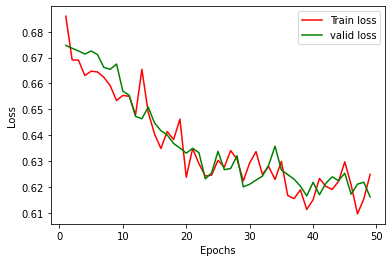

In [153]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


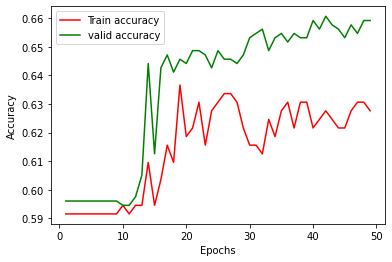

In [154]:
plt.plot([i for i in range(1,epochs)],[i for i  in teste_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,epochs)],[i  for i in vale_accuracy],label="valid accuracy",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


In [155]:
print(f"Training loss|   Mean: {torch.tensor(epoch_loss).mean()}   std: {torch.tensor(epoch_loss).std()}")
print(f"validation loss| Mean: {torch.tensor(valida_loss).mean()}  std: {torch.tensor(valida_loss).std()}")
print(f"Test loss|       Mean: {torch.tensor(test_loss).mean()}   std: {torch.tensor(test_loss).std()}")

Training loss|   Mean: 0.636268138885498   std: 0.01850801147520542
validation loss| Mean: 0.6373651027679443  std: 0.018760930746793747
Test loss|       Mean: 0.6135731935501099   std: nan
